In [1]:
import pandas as pd

# Read Shipping Status Data
df1 = pd.read_excel('/Users/edwzhang/Downloads/Shipment Status/Shipment_Status_-324123132_Masked.xlsx')
df2 = pd.read_excel('/Users/edwzhang/Downloads/Shipment Status/Shipment_Status_-324123133_Masked.xlsx')
df_ship = pd.concat([df1,df2],ignore_index=True)
del df_ship['Unnamed: 5']


In [2]:
# Read Shipping Details Data
df_detail = pd.read_excel('/Users/edwzhang/Downloads/Shipment Execution-selected/Shipment Exec Jan 3.xls')
df_detail= df_detail.drop(['CONTAINER_TYPE','DIM_UOM','WEIGHT_UOM','SO_HEADER_ID','SO_LINE_ID','PO_NUMBER','EARLY_DELIVERY_ACCEPT_FLAG','SHIPPING_INSTRUCTIONS','SERVICE_ATTACHED','CUST_PO_NUMBER','CUST_DELIV_ACCPT_REQRD','INSURRED','DUTY_ATTRIBUTE','EXPORT_LICENSE_REQD','EXPEDITED','PRE_DELIV_INSPECTION','ACTION_STATUS','RECOMMITTED','MFG_COMPLEXITY','COMP_LABEL','SOFTWARE_INCLUDED'], axis=1)
df_detail=df_detail.drop_duplicates()


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [3]:
# Merge both data
df3 = pd.merge(df_detail,df_ship,left_on= 'CARTON_ID',right_on='CONTAINER ID')

In [17]:
# For Testinf only
for name, group in df3[['CONTAINER ID','STATUS','DATE','MODE']].groupby('CONTAINER ID',group_keys=False):
    if group.shape[0] == 8:
        print name
        print group
        print max(group['DATE']),min(group['DATE'])
        print (max(group['DATE'])-min(group['DATE'])).days
        print group['MODE'].unique()[0]
        

###2472#9%
      CONTAINER ID                 STATUS       DATE MODE
57157   ###2472#9%       CUSTOM CLEARANCE 2016-01-26  AIR
57158   ###2472#9%          LATE_DELIVERY 2016-01-25  AIR
57159   ###2472#9%               WHEELSUP 2016-01-25  AIR
57160   ###2472#9%  Received in Warehouse 2016-01-06  AIR
57161   ###2472#9%          Ready To Ship 2016-01-06  NaN
57162   ###2472#9%          LATE_WHEELSUP 2016-01-25  AIR
57163   ###2472#9%        LATE_WHEELSDOWN 2016-01-25  AIR
57164   ###2472#9%             WHEELSDOWN 2016-01-27  AIR
2016-01-27 00:00:00 2016-01-06 00:00:00
21
AIR
#*5##74@*52
     CONTAINER ID                 STATUS       DATE MODE
2417  #*5##74@*52       CUSTOM CLEARANCE 2016-01-14  AIR
2418  #*5##74@*52             WHEELSDOWN 2016-01-13  AIR
2419  #*5##74@*52        LATE_WHEELSDOWN 2016-01-13  AIR
2420  #*5##74@*52  Received in Warehouse 2016-01-09  AIR
2421  #*5##74@*52               WHEELSUP 2016-01-12  AIR
2422  #*5##74@*52          Ready To Ship 2016-01-08  NaN
2423  #*5

In [18]:
# Define a function to return Shipping Days and Main Shipping Method(Air or Ground)
def getTimeNMode(group):
    return pd.Series([(max(group['DATE'])-min(group['DATE'])).days,group['MODE'].unique()[0]],index=['ShippingDays','ShippingMode'])

df4 = df3[['CONTAINER ID','STATUS','DATE','MODE']].groupby('CONTAINER ID',group_keys=False).apply(getTimeNMode)
df4 = df4.reset_index()
df5 = pd.merge(df_detail,df4,left_on= 'CARTON_ID',right_on='CONTAINER ID')

In [24]:
# Testing Only
#df5['ShippingDays'].value_counts()
#df4.loc[df4['ShippingDays']==1,'CONTAINER ID']
df_ship.loc[df_ship['CONTAINER ID']=='###24669*6',]
#df_detail.loc[df_detail['CARTON_ID']=='###24669*6',]


In [27]:
# ShippingDays must be great than 0 and less than 30 to train the Regression Model
df6 = df5.loc[(df5['ShippingDays']>0) & (df5['ShippingDays']<30),]


In [248]:
# Define a function to extract OTM route code 
def getInTransitStopOvers(data,row=True):
    try:
        if row:
            code = data['OTM_ROUTE_CODE']
        else:
            code = data

        codes = []
        if len(code) > 0  and code.count('-') >0:
            codes = code.split('-')
            if codes[0] in ['COC','CDC']:
                codes.append('NA')
            elif codes[0] == 'CC':
                codes[1] = 'NA'
                codes.append('NA')
        else:
            codes = ['','','']
        return pd.Series(codes,index=['RouteType','StopOver1','StopOver2'])
    except Exception, e:
        print code, ' failed in parsing In-Transit StopOvers with the error '+str(e) 
        return pd.Series(['','',''],index=['RouteType','StopOver1','StopOver2'])

df6['OTM_ROUTE_CODE'].fillna('', inplace=True)
df6[['RouteType','OriSLC','DesSLC']] = df6.apply(getInTransitStopOvers,axis=1)


In [249]:
# Define a function to extrac Shipping Method
def getDeliveryData(data,row=True):
    try:
        if row:
            method = data['SHIPPING_METHOD_CODE']
        else:
            method = data
        methods = []
        if method.count('_') >2:
            methods = method.split('_',3)
        else:
            methods = ['','','','']
        return pd.Series(methods[1:],index=['Carrier','DeliveryType','DeliveryPriority'])
    except Exception, e:
        print method + ' failed in parsing Delivery Data with the error '+str(e) 
        return pd.Series(['','',''],index=['Carrier','DeliveryType','DeliveryPriority'])
    
df6['SHIPPING_METHOD_CODE'].fillna('', inplace=True)
df6[['Carrier','DeliveryType','DeliveryPriority']] = df6.apply(getDeliveryData, axis=1)


In [250]:
# Define a function to extract product dimension
def getCarbonDimensions(data,row=True):
    try:
        if row:
            dimension = str(data['CART_DIM'])
        else:
            dimension = data
        dimensions = []
        if dimension.count('X') >1:
            dimensions = [float(d.strip()) for d in dimension.split('X',3)] 
        else:
            dimensions = [0.0,0.0,0.0]
        return pd.Series(dimensions,index=['Length','Width','Height'])
    except Exception, e:
        print dimension, ' failed in parsing dimensions with the error '+str(e) 
        return pd.Series([0.0,0.0,0.0],index=['Length','Width','Height'])

df6['CART_DIM'].fillna(0.0, inplace=True)
df6[['Length','Width','Height']] = df6.apply(getCarbonDimensions, axis=1)


In [252]:
# Define Encode and Decode functions
from sklearn.externals import joblib
def categoryEncoding(col,ColName):
    colDict = {}
    colSet = set([i for i in col])
    i = 1
    for j in colSet:
        colDict[j] = i
        i += 1
    joblib.dump(colDict, '/Users/edwzhang/Downloads/Shipment Status/dict_'+ColName) 
    return colDict
        
def encodingLookup(ColName, val):
    colDict = joblib.load('/Users/edwzhang/Downloads/Shipment Status/dict_'+ColName) 
    if val in colDict:
        return colDict[val]
    else:
        return colDict[max(colDict)] +1


In [253]:
# Train the Regression Model
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler


df6['ShippingMode'].fillna('', inplace=True)
df6['ORDERED_ITEM'].fillna('', inplace=True)
# Encode Categorical Varibales to Numeric
cols = ['ShippingDays','WEIGHT','SHIP_FROM_ORG_ID','TO_CITY','ShippingMode','RouteType','OriSLC','DesSLC','Carrier','Length','Width','Height','ORDERED_ITEM']
df_model = df6.loc[(df6['OTM_ROUTE_CODE']!='') & (df6['SHIPPING_METHOD_CODE']!='') &(df6['CART_DIM']!=0.0) ,cols]
df_model = df6.loc[(df6['OTM_ROUTE_CODE']!='') & (df6['SHIPPING_METHOD_CODE']!='') &(df6['CART_DIM']!=0.0) ,cols]
cols2 = ['TO_CITY','ShippingMode','RouteType','OriSLC','DesSLC','Carrier','ORDERED_ITEM']
for colName in cols2:
    #le = LabelEncoder()
    #df_model[colName] = le.fit_transform(df_model[colName])
    colDict = categoryEncoding(df_model[colName],colName)
    df_model[colName] = df_model[colName].apply(lambda x:colDict[x])
    
# Split into Training and Testing set
train_set, test_set = train_test_split(df_model, test_size=0.2)
X_train = train_set.iloc[:,1:]
y_train = train_set.iloc[:,0]

X_test = test_set.iloc[:,1:]
y_test = test_set.iloc[:,0]

# Fit the Model
regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(X_train, y_train)

# Print out the R squared score
regressor.score(X_test,y_test)

0.33205304657957002

In [327]:
# Persist the model
joblib.dump(regressor, '/Users/edwzhang/Downloads/Shipment Status/CiscoSupplyChainAnalyticsRegressor.pkl') 

# List feature importance
s = pd.Series(regressor.feature_importances_,index=cols[1:])
s.sort_values(ascending=False)


TO_CITY             0.220305
WEIGHT              0.217182
ORDERED_ITEM        0.146435
Width               0.066100
Height              0.064284
Carrier             0.063671
Length              0.063162
ShippingMode        0.061145
SHIP_FROM_ORG_ID    0.033055
OriSLC              0.031306
DesSLC              0.020439
RouteType           0.012917
dtype: float64

In [325]:
# Create a custom function to predict Shipping days
def customPredict(data):
    rgr_loaded = joblib.load('/Users/edwzhang/Downloads/Shipment Status/CiscoSupplyChainAnalytics.pkl') 
    feedData = []
    
    l1 = list(getInTransitStopOvers(data['OTM_ROUTE_CODE'],row=False))
    l2 = list(getDeliveryData(data['SHIPPING_METHOD_CODE'],row=False))
    l3 = list(getCarbonDimensions(data['CART_DIM'],row=False))
    
    feedData.append(data['WEIGHT'])
    feedData.append(data['SHIP_FROM_ORG_ID'])
    feedData.append(encodingLookup('TO_CITY',data['TO_CITY']))
    feedData.append(encodingLookup('ShippingMode',l2[1]))  
    feedData.append(encodingLookup('RouteType',l1[0]))
    feedData.append(encodingLookup('OriSLC',l1[1]))
    feedData.append(encodingLookup('DesSLC',l1[2]))
    feedData.append(encodingLookup('Carrier',l2[0]))
    feedData.append(l3[0])
    feedData.append(l3[1])
    feedData.append(l3[2])
    feedData.append(encodingLookup('ORDERED_ITEM',data['ORDERED_ITEM']))
    #print feedData
    data['CARRIER'] = l2[0]
    data['SHIPPINGMODE'] = l2[1]
    data['ROUTETYPE'] = l1[0]
    data['ORISLC'] = l1[1]
    data['DESSLC'] = l1[2]
    data['DAYS'] = round(rgr_loaded.predict(feedData)[0],2)
    return data
      

In [326]:
input_dict = {
'PROMISED_POINT':'SHIP',
'CARTON_ID': '#*7@27#77#',
'CONTAINER_TYPE': 'CRT',
'CART_DIM': '9.38 X 7.38 X 2.5',
'DIM_UOM': 'IN',
'WEIGHT':  '1.82',
'WEIGHT_UOM': 'LBS',
'SHIPMENT_ID': '22*%%@%654',
'SO_HEADER_ID':  '603771708',
'SO_LINE_ID': '950866183',
'PO_NUMBER': '101665066-1',
'FROM_CITY':  'Pardubice',
'TO_CITY':  'JERUSALEM',
'SHIP_SET_ID': '6*956@46#',
'OTM_ROUTE_CODE':  'CDC-SLCROERMOND',
'SHIPPING_METHOD_CODE': '000002_FDEN_L_LTL',
'EARLY_DELIVERY_ACCEPT_FLAG': 'Y',
'SHIPMENT_PRIORITY_CODE': 'PR9',
'SHIPPING_INSTRUCTIONS':  '',
'SERVICE_ATTACHED':  '',
'CUST_PO_NUMBER':  '8740012372',
'TRIM(OEL.REQUEST_DATE)':'2015-12-28 00:00:00',
'TRIM(OLX.ORIGINAL_PROMISE_DATE)':'2015-12-28 00:00:00',
'TRIM(OEL.PROMISE_DATE)':'2015-12-28 00:00:00',
'ACTUAL_SHIPMENT_DATE': '2015-12-28 08:55:30',
'CUST_DELIV_ACCPT_REQRD': '',
'ORDER_NUMBER': '1.01665e+08',
'LINE_NUMBER':  '1',
'ORDERED_ITEM': 'STACK-T1-50CM=',
'SHIP_FROM_ORG_ID': '1103',
'PRE_DELIV_INSPECTION': 'N',
'INSURRED':  'Y',
'DUTY_ATTRIBUTE': 'Duty Unpaid',
'EXPORT_LICENSE_REQD': 'Y',
'EXPEDITED':  '',
'ACTION_STATUS':  '',
'RECOMMITTED':  'N',
'MFG_COMPLEXITY': 'LOW',
'MFG_LEAD_TIME': '3',
'COMP_LABEL':'N',
'SOFTWARE_INCLUDED': 'N'}
customPredict(input_dict)

/Users/edwzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


{'ACTION_STATUS': '',
 'ACTUAL_SHIPMENT_DATE': '2015-12-28 08:55:30',
 'CARRIER': 'FDEN',
 'CARTON_ID': '#*7@27#77#',
 'CART_DIM': '9.38 X 7.38 X 2.5',
 'COMP_LABEL': 'N',
 'CONTAINER_TYPE': 'CRT',
 'CUST_DELIV_ACCPT_REQRD': '',
 'CUST_PO_NUMBER': '8740012372',
 'DAYS': 6.53,
 'DESSLC': 'NA',
 'DIM_UOM': 'IN',
 'DUTY_ATTRIBUTE': 'Duty Unpaid',
 'EARLY_DELIVERY_ACCEPT_FLAG': 'Y',
 'EXPEDITED': '',
 'EXPORT_LICENSE_REQD': 'Y',
 'FROM_CITY': 'Pardubice',
 'INSURRED': 'Y',
 'LINE_NUMBER': '1',
 'MFG_COMPLEXITY': 'LOW',
 'MFG_LEAD_TIME': '3',
 'ORDERED_ITEM': 'STACK-T1-50CM=',
 'ORDER_NUMBER': '1.01665e+08',
 'ORISLC': 'SLCROERMOND',
 'OTM_ROUTE_CODE': 'CDC-SLCROERMOND',
 'PO_NUMBER': '101665066-1',
 'PRE_DELIV_INSPECTION': 'N',
 'PROMISED_POINT': 'SHIP',
 'RECOMMITTED': 'N',
 'ROUTETYPE': 'CDC',
 'SERVICE_ATTACHED': '',
 'SHIPMENT_ID': '22*%%@%654',
 'SHIPMENT_PRIORITY_CODE': 'PR9',
 'SHIPPINGMODE': 'L',
 'SHIPPING_INSTRUCTIONS': '',
 'SHIPPING_METHOD_CODE': '000002_FDEN_L_LTL',
 'SHIP_FRO

In [307]:
# Lable - 'ShippingDays',
# 'WEIGHT',
# 'SHIP_FROM_ORG_ID',
# 'TO_CITY',
# 'ShippingMode',
# 'RouteType',
# 'OriSLC',
# 'DesSLC',
# 'Carrier',
# 'Length',
# 'Width',
# 'Height',
# 'ORDERED_ITEM'
feedData = [1.82, 1103, encodingLookup('TO_CITY','JERUSALEM'), encodingLookup('ShippingMode','Ocean'), encodingLookup('RouteType','CDC'), encodingLookup('OriSLC','NA'), encodingLookup('DesSLC','SLCROERMOND'), encodingLookup('Carrier','CPU'), 9.3800000000000008, 7.3799999999999999, 2.5, 841]
regressor.predict(feedData)

/Users/edwzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [317]:
print df6['DeliveryType'].value_counts()
print df6['ShippingMode'].value_counts()

L    21053
A      577
P      421
T       96
O       35
Name: DeliveryType, dtype: int64
AIR         5800
            5605
LTL         4711
PARCEL      4043
TL          1998
Ocean         24
3_5_DAYS       1
Name: ShippingMode, dtype: int64


In [311]:
#fromCity = df6[['SHIP_FROM_ORG_ID','FROM_CITY']].drop_duplicates().reset_index()
#fromCity.loc[fromCity['SHIP_FROM_ORG_ID']==2246,'FROM_CITY'] = 'Foxconn-China-BV'
#fromCity.loc[fromCity['SHIP_FROM_ORG_ID']==843,'FROM_CITY'] = 'Celestica Thailand-BV'

fromCityDict = pd.Series(fromCity.FROM_CITY.values,index=fromCity.SHIP_FROM_ORG_ID).to_dict()

joblib.dump(fromCityDict, '/Users/edwzhang/Downloads/Shipment Status/dict_FROM_CITY') 


['/Users/edwzhang/Downloads/Shipment Status/dict_FROM_CITY']

In [312]:
fromCityDict

{123: u'Ciudad Juarez',
 362: u'AUSTIN',
 383: u'Zapopan',
 463: u'Penang',
 483: u'Penang',
 843: 'Celestica Thailand-BV',
 1103: u'Pardubice',
 1163: u'Houston',
 1348: u'Doumen',
 2246: 'Foxconn-China-BV',
 2645: u'Balbriggan',
 2665: u'Louisville',
 2705: u'Guadalajara',
 2725: u'Tczew',
 2726: u'Millington',
 2766: u'Ciudad Juarez',
 2786: u'GA',
 2787: u'Tsing Yi',
 2826: u'SAO PAULO'}

In [304]:
df6['FROM_CITY'].value_counts()

Pardubice        5112
Ciudad Juarez    4946
Houston          1540
Zapopan          1373
Guadalajara      1109
Penang            907
Tczew             889
Doumen            557
Tsing Yi          168
Millington         58
GA                 34
SAO PAULO          29
AUSTIN             24
Louisville         24
Balbriggan          6
Name: FROM_CITY, dtype: int64

In [221]:
df6['ShippingMode'].fillna('', inplace=True)
df6['ORDERED_ITEM'].fillna('', inplace=True)
cols = ['ShippingDays','WEIGHT','SHIP_FROM_ORG_ID','TO_CITY','ShippingMode','RouteType','OriSLC','DesSLC','Carrier','Length','Width','Height','ORDERED_ITEM']
df_model = df6.loc[(df6['OTM_ROUTE_CODE']!='') & (df6['SHIPPING_METHOD_CODE']!='') &(df6['CART_DIM']!=0.0) ,cols]
df_model = df6.loc[(df6['OTM_ROUTE_CODE']!='') & (df6['SHIPPING_METHOD_CODE']!='') &(df6['CART_DIM']!=0.0) ,cols]
cols2 = ['TO_CITY','ShippingMode','RouteType','OriSLC','DesSLC','Carrier','ORDERED_ITEM']
for colName in cols2:
    colDict = categoryEncoding(df_model[colName],colName)
    df_model[colName] = df_model[colName].apply(lambda x:colDict[x])

In [226]:
df_model['ORDERED_ITEM'].value_counts()
#df6['ORDERED_ITEM'].value_counts()
#encodingLookup('ORDERED_ITEM','C888EA-K9')

2048    510
1278    436
1752    353
929     331
305     289
489     267
1150    247
2217    232
820     230
869     228
1618    219
1089    208
1453    199
1384    194
2471    189
1568    181
2371    180
833     173
209     169
1919    160
1856    146
2100    131
2151    131
478     124
1911    123
320     115
807     114
1725    112
1775    106
2254    104
       ... 
932       1
1768      1
1140      1
766       1
1108      1
1092      1
1076      1
205       1
782       1
1028      1
1816      1
1848      1
964       1
948       1
1880      1
644       1
862       1
189       1
836       1
894       1
1960      1
788       1
173       1
756       1
9         1
724       1
910       1
25        1
926       1
1991      1
Name: ORDERED_ITEM, Length: 2535, dtype: int64

In [208]:
df6.columns.values

array([u'PROMISED_POINT', u'CARTON_ID', u'CART_DIM', u'WEIGHT',
       u'SHIPMENT_ID', u'FROM_CITY', u'TO_CITY', u'SHIP_SET_ID',
       u'OTM_ROUTE_CODE', u'SHIPPING_METHOD_CODE',
       u'SHIPMENT_PRIORITY_CODE', u'TRIM(OEL.REQUEST_DATE)',
       u'TRIM(OLX.ORIGINAL_PROMISE_DATE)', u'TRIM(OEL.PROMISE_DATE)',
       u'ACTUAL_SHIPMENT_DATE', u'ORDER_NUMBER', u'LINE_NUMBER',
       u'ORDERED_ITEM', u'SHIP_FROM_ORG_ID', u'MFG_LEAD_TIME',
       'CONTAINER ID', 'ShippingDays', 'ShippingMode', 'RouteType',
       'OriSLC', 'DesSLC', 'Carrier', 'DeliveryType', 'DeliveryPriority',
       'Length', 'Width', 'Height'], dtype=object)

In [71]:
from sklearn.externals import joblib
def getInTransitStopOvers(row):
    try:
        code = row['OTM_ROUTE_CODE']
        #code = row
        codes = []
        if len(code) > 0  and code.count('-') >0:
            codes = code.split('-')
            if codes[0] in ['COC','CDC']:
                codes.append('NA')
            elif codes[0] == 'CC':
                codes[1] = 'NA'
                codes.append('NA')
        else:
            codes = ['','','']
        return pd.Series(codes,index=['RouteType','StopOver1','StopOver2'])
    except Exception, e:
        print code, ' failed in parsing In-Transit StopOvers with the error '+str(e) 
        return pd.Series(['','',''],index=['RouteType','StopOver1','StopOver2'])

df6['OTM_ROUTE_CODE'].fillna('', inplace=True)
df6[['RouteType','OriSLC','DesSLC']] = df6.apply(getInTransitStopOvers,axis=1)

/Users/edwzhang/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [72]:
def getDeliveryData(row):
    try:
        method = row['SHIPPING_METHOD_CODE']
        #method = row
        methods = []
        if method.count('_') >2:
            methods = method.split('_',3)
        else:
            methods = ['','','','']
        return pd.Series(methods[1:],index=['Carrier','DeliveryType','DeliveryPriority'])
    except Exception, e:
        print method + ' failed in parsing Delivery Data with the error '+str(e) 
        return pd.Series(['','',''],index=['Carrier','DeliveryType','DeliveryPriority'])
    
df6['SHIPPING_METHOD_CODE'].fillna('', inplace=True)
df6[['Carrier','DeliveryType','DeliveryPriority']] = df6.apply(getDeliveryData, axis=1)

In [73]:
def getCarbonDimensions(row):
    try:
        dimension = str(row['CART_DIM'])
        #dimension = row
        dimensions = []
        if dimension.count('X') >1:
            dimensions = [float(d.strip()) for d in dimension.split('X',3)] 
        else:
            dimensions = [0.0,0.0,0.0]
        return pd.Series(dimensions,index=['Length','Width','Height'])
    except Exception, e:
        print dimension, ' failed in parsing dimensions with the error '+str(e) 
        return pd.Series([0.0,0.0,0.0],index=['Length','Width','Height'])

df6['CART_DIM'].fillna(0.0, inplace=True)
df6[['Length','Width','Height']] = df6.apply(getCarbonDimensions, axis=1)

In [83]:
cols = ['ShippingDays','PROMISED_POINT','WEIGHT','TO_CITY','SHIP_FROM_ORG_ID','ShippingMode','RouteType','OriSLC','DesSLC','Carrier','DeliveryType','DeliveryPriority','Length','Width','Height']
df_model = df6.loc[(df6['OTM_ROUTE_CODE']!='') & (df6['SHIPPING_METHOD_CODE']!='') &(df6['CART_DIM']!=0.0) ,cols]

In [120]:
def categoryEncoding(col,ColName):
    colDict = {}
    colSet = set([i for i in col])
    i = 1
    for j in colSet:
        colDict[j] = i
        i += 1
    joblib.dump(colDict, '/home/felix/jupyter/data/dict_'+ColName) 
    return colDict
        
def encodingLookup(ColName, val):
    colDict = joblib.load('/home/felix/jupyter/data/dict_'+ColName) 
    if val in colDict:
        return colDict[val]
    else:
        return colDict[max(colDict)] +1

In [189]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler

df_model = df6.loc[(df6['OTM_ROUTE_CODE']!='') & (df6['SHIPPING_METHOD_CODE']!='') &(df6['CART_DIM']!=0.0) ,cols]
cols2 = ['PROMISED_POINT','TO_CITY','ShippingMode','RouteType','OriSLC','DesSLC','Carrier','DeliveryType','DeliveryPriority']
for colName in cols2:
    le = LabelEncoder()
    df_model[colName] = le.fit_transform(df_model[colName])
    


train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)
X_train = train_set.iloc[:,1:]

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)

y_train = train_set.iloc[:,0]




X_test = test_set.iloc[:,1:]

#scaler = StandardScaler()
#X_test = scaler.fit_transform(X_test)

y_test = test_set.iloc[:,0]


regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(X_train, y_train)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [182]:
df_model[:3]

array([[-0.62602187,  0.92970661,  6.40794919, -1.10465527,  1.1409397 ,
        -3.34277403, -2.66132363, -2.36045216, -0.43108952, -0.0705132 ,
        -0.07177703,  0.26534963,  3.95358067,  1.42477352,  1.19095541],
       [-0.82163158, -0.91221213, -0.02080959,  0.13347593,  0.49853565,
         0.48264247,  0.20209716, -0.80720575, -0.43108952, -0.0705132 ,
        -0.07177703,  0.26534963, -0.28265526, -0.13194701,  0.07534022],
       [-0.43041215, -0.91221213,  0.49237503, -1.36906973, -0.78984136,
         0.48332717,  1.63380755, -0.28945694,  2.05061226, -0.0705132 ,
        -0.07177703,  0.26534963,  2.83381762,  0.79595711, -0.03867626]])

In [168]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) 
X_poly = poly_features.fit_transform(X_train)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)


predict = lin_reg.predict(poly_features.fit_transform(X_test))

print predict[40:50]
print y_test[40:50]


[ 6.94051188  5.73360534  7.82106416  6.88291871  3.98180063  4.81130468
  2.6071789   3.89769391  5.68977779  7.36883537]
30483     4
37012     6
18397    11
18245     7
8884      2
33470     3
24742     1
30501     2
4474     16
25980     5
Name: ShippingDays, dtype: int64


In [152]:
from sklearn.grid_search import GridSearchCV


param_grid = [{'n_estimators': [400,600,800], 'max_depth':[3,5,7]}]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [400, 600, 800], 'max_depth': [3, 5, 7]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [153]:
grid_search.grid_scores_


[mean: 0.07051, std: 0.00737, params: {'n_estimators': 400, 'max_depth': 3},
 mean: 0.07064, std: 0.00705, params: {'n_estimators': 600, 'max_depth': 3},
 mean: 0.07075, std: 0.00710, params: {'n_estimators': 800, 'max_depth': 3},
 mean: 0.11857, std: 0.00832, params: {'n_estimators': 400, 'max_depth': 5},
 mean: 0.11920, std: 0.00810, params: {'n_estimators': 600, 'max_depth': 5},
 mean: 0.11899, std: 0.00841, params: {'n_estimators': 800, 'max_depth': 5},
 mean: 0.16911, std: 0.00760, params: {'n_estimators': 400, 'max_depth': 7},
 mean: 0.16944, std: 0.00747, params: {'n_estimators': 600, 'max_depth': 7},
 mean: 0.16948, std: 0.00775, params: {'n_estimators': 800, 'max_depth': 7}]

In [187]:
predict = regressor.predict(X_test)

print predict[40:50]
print y_test[40:50]



[  7.67656667   6.03783333   6.79158095  10.58641667   1.438        5.99617128
   3.68886667   1.719        7.26943333   9.82576667]
30483     4
37012     6
18397    11
18245     7
8884      2
33470     3
24742     1
30501     2
4474     16
25980     5
Name: ShippingDays, dtype: int64


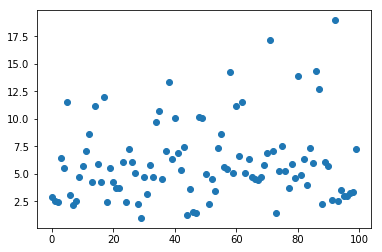

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(range(100),predict[:100])


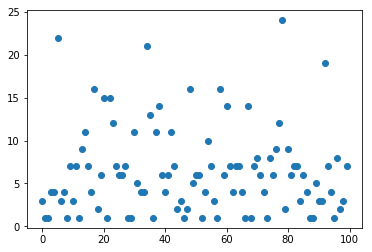

In [164]:
plt.scatter(range(100),y_test[:100])

In [190]:
print regressor.score(X_test,y_test)

#print regressor.feature_importances_
#for i in range(len(cols)-1):
#    print cols[i+1],regressor.feature_importances_[i]
    
#s = pd.Series(regressor.feature_importances_,index=cols[1:])
#s.sort_values(ascending=False)

0.256011909764


In [119]:
regressor = RandomForestRegressor(n_estimators=500,max_features=8)
regressor.fit(X_train, y_train)

X_test = test_set.iloc[:,1:]
y_test = test_set['ShippingDays']
regressor.score(X_test,y_test)

2

In [117]:
regressor.fit(X_train, y_train)
regressor.predict(test_set.iloc[0,1:])

ValueError: could not convert string to float: LTL

In [114]:
#df_model['ShippingMode'].value_counts()
#train_set['ShippingMode'].value_counts()
test_set.iloc[0]

ShippingDays                  3
PROMISED_POINT          ARRIVAL
WEIGHT                  4.27696
TO_CITY                 Swindon
SHIP_FROM_ORG_ID           2725
ShippingMode                AIR
RouteType                   CDC
OriSLC              SLCROERMOND
DesSLC                       NA
Carrier                     CPU
DeliveryType                  L
DeliveryPriority            LTL
Length                     16.5
Width                      5.94
Height                     4.75
Name: 27264, dtype: object

In [ ]:
X = np.asarray([('a',1,2),('b',2,3),('a',3,2),('c',1,3)]) 
y = np.asarray([1,2.5,3,4])

# transform 1st column to numbers
X[:, 0] = LabelEncoder().fit_transform(X[:,0]) 

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

regressor = RandomForestRegressor(n_estimators=150, min_samples_split=1)
regressor.fit(X, y)
print X
print regressor.predict(X)

In [ ]:

df.loc[df['CONTAINER ID'] == '#*##92*%69',].sort_index(by='DATE')

In [ ]:
df_detail = pd.read_excel('/Users/edwzhang/Downloads/Shipment Execution-selected/Shipment Exec Jan 3.xls')


In [ ]:
#df1['CARTON_ID'].value_counts()
#df1.loc[df1['CARTON_ID'] == '#*6#*@9%@9%',]
df_detail= df_detail.drop(['CONTAINER_TYPE','DIM_UOM','WEIGHT_UOM','SO_HEADER_ID','PO_NUMBER','SO_LINE_ID','EARLY_DELIVERY_ACCEPT_FLAG','SHIPPING_INSTRUCTIONS','SERVICE_ATTACHED','CUST_PO_NUMBER','CUST_DELIV_ACCPT_REQRD','INSURRED','DUTY_ATTRIBUTE','EXPORT_LICENSE_REQD','EXPEDITED','PRE_DELIV_INSPECTION','ACTION_STATUS','RECOMMITTED','MFG_COMPLEXITY','COMP_LABEL','SOFTWARE_INCLUDED'], axis=1)
df_detail=df_detail.drop_duplicates()

In [ ]:

df3 = pd.merge(df_detail,df_ship,left_on= 'CARTON_ID',right_on='CONTAINER ID')

In [ ]:
#df3['CARTON_ID'].value_counts()
df3.loc[df3['CONTAINER ID'] == '#*6#*92@6%*',['FROM_CITY','TO_CITY','TRIM(OEL.PROMISE_DATE)','ACTUAL_SHIPMENT_DATE','STATUS','DATE','LOCATION']].sort_index(by='DATE')


In [ ]:
df_ship.groupby('CONTAINER ID').size()